In [1]:
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.integrate

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.plotting

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

# Pevent bulky altair plots
alt.data_transformers.enable('json')

Loading BokehJS ...

DataTransformerRegistry.enable('json')

In [2]:
df = pd.read_csv('../data/130315_1A_aanat2.csv', comment='#')

# Load in the genotype file, call it df_gt for genotype DataFrame
df_gt = pd.read_csv('../data/130315_1A_genotypes.txt',
                    delimiter='\t',
                    comment='#',
                    header=[0, 1])

# Reset the columns to be the second level of indexing
df_gt.columns = df_gt.columns.get_level_values(1)

# Check out the new columns
df_gt.columns

df_gt.columns = ['wt', 'het', 'mut']

# Tidy the DataFrame
df_gt = pd.melt(df_gt, var_name='genotype', value_name='location')

# Drop all rows that have a NaN in them
df_gt = df_gt.dropna()

df_gt = df_gt.reset_index(drop=True)

df_gt.loc[:,'location'] = df_gt.loc[:, 'location'].astype(int)

df = pd.merge(df, df_gt)

df['time'] = pd.to_datetime(df['time'])

df['light'] = (  (df['time'].dt.time >= pd.to_datetime('9:00:00').time())
               & (df['time'].dt.time < pd.to_datetime('23:00:00').time()))

In [3]:
df.head()

,location,activity,time,zeit,zeit_ind,day,genotype,light
0,1,0.6,2013-03-15 18:31:09,-14.480833,-869,4,het,True
1,1,1.9,2013-03-15 18:32:09,-14.464167,-868,4,het,True
2,1,1.9,2013-03-15 18:33:09,-14.447500,-867,4,het,True
3,1,13.4,2013-03-15 18:34:09,-14.430833,-866,4,het,True
4,1,15.4,2013-03-15 18:35:09,-14.414167,-865,4,het,True


In [16]:
df.shape[0]
# we dropped fish?

391499

In [5]:
dataframes = []
for i in range(1, 97):
    dataframes.append(df[df['location'] == i])


In [6]:
frames = []
for i in range(96):
    if dataframes[i].shape[0] != 0:
        frames.append(dataframes[i])

In [7]:
# Get the activity level of all the fish together!

counter1 = 0
counter2 = 0
counter3 = 0
counter4 = 0
total_data = []
for i, d in enumerate(frames):
    data = []
    inactive_minutes_count = 0
    counter = 0
    for index, row in d.iterrows():
        if row['activity'] < 1: # our fishy is still inactive
            inactive_minutes_count += 1
            counter1 += 1
            
        else: # we are in a period of activity
            if inactive_minutes_count == 0:
                data.append(0)
                counter2 += 1

            else: # we are coming from a period of inactivity
                data += [inactive_minutes_count] + [0] * (inactive_minutes_count - 1) + [0]
                inactive_minutes_count = 0
                counter3 += 1

        
        if counter == d.shape[0] - 1: # we are at the end and are still inactive, manually add
            #print (i)
            data += [inactive_minutes_count] + [0] * (inactive_minutes_count - 1)
            counter4 += 1
            
        counter += 1
        
    total_data += data[:5363]
            
#     if len(data) % 5363 != 0:
#         data = data[:len(data) - 1]
        
#     print ('total iterations: ' + str(counter))
    
#     print ('length of calculated data array: ' + str(len(data)))
#     df_1 = df[df["location"] == i + 1]
#     print ('length of dataframe: ' + str(df_1.shape[0]))

#     df_1["InactivityBegun" + str(i)] = np.array(data[:df_1.shape[0]])

In [8]:
df["InactivityBegun" ] = np.array(total_data)

In [9]:
df.head()

,location,activity,time,zeit,zeit_ind,day,genotype,light,InactivityBegun
0,1,0.6,2013-03-15 18:31:09,-14.480833,-869,4,het,True,1
1,1,1.9,2013-03-15 18:32:09,-14.464167,-868,4,het,True,0
2,1,1.9,2013-03-15 18:33:09,-14.447500,-867,4,het,True,0
3,1,13.4,2013-03-15 18:34:09,-14.430833,-866,4,het,True,0
4,1,15.4,2013-03-15 18:35:09,-14.414167,-865,4,het,True,0


In [10]:
print (len(total_data) - 391499)

0


In [47]:
df_inactive = df[df["InactivityBegun"] > 5]

In [48]:
df_inactive.head()

,location,activity,time,zeit,zeit_ind,day,genotype,light,InactivityBegun
11,1,0.0,2013-03-15 18:42:09,-14.297500,-858,4,het,True,88
100,1,0.0,2013-03-15 20:11:09,-12.814167,-769,4,het,True,39
149,1,0.0,2013-03-15 21:00:09,-11.997500,-720,4,het,True,119
272,1,0.9,2013-03-15 23:03:09,-9.947500,-597,4,het,False,24
300,1,0.0,2013-03-15 23:31:09,-9.480833,-569,4,het,False,9


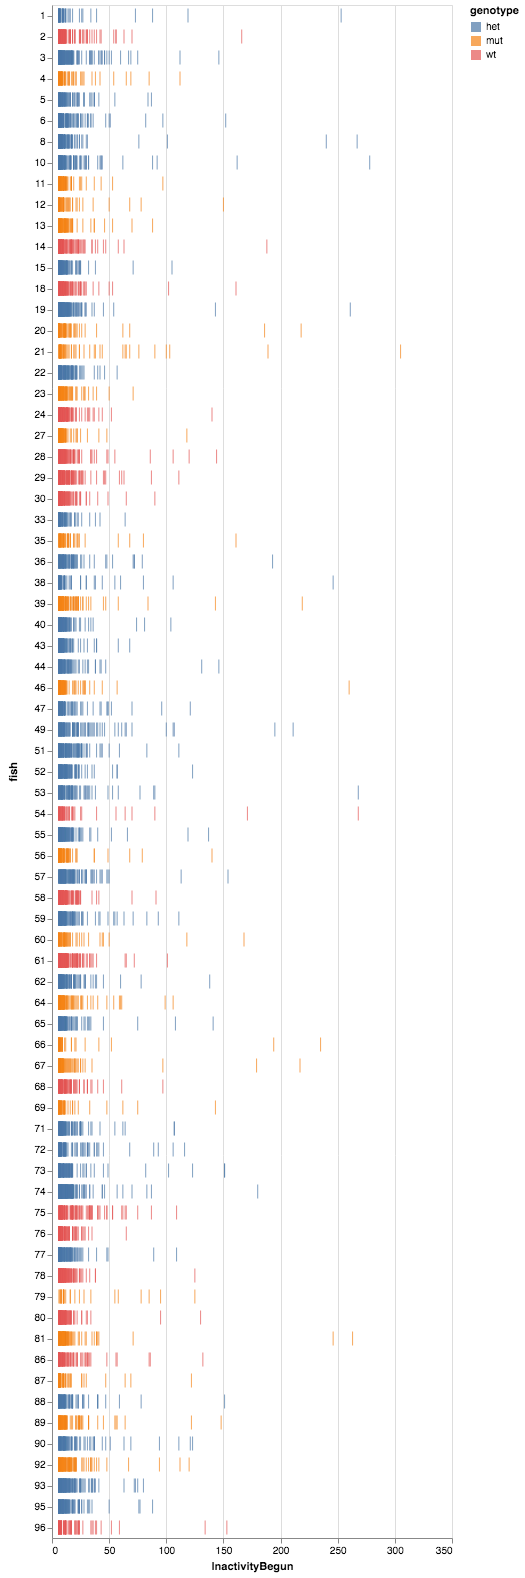

In [49]:
alt.Chart(df_inactive
    ).mark_tick(
    ).encode(
        x='InactivityBegun:Q',
        y=alt.Y('location:N', title='fish'),
        color=alt.Color('genotype:N', title="genotype")
    )

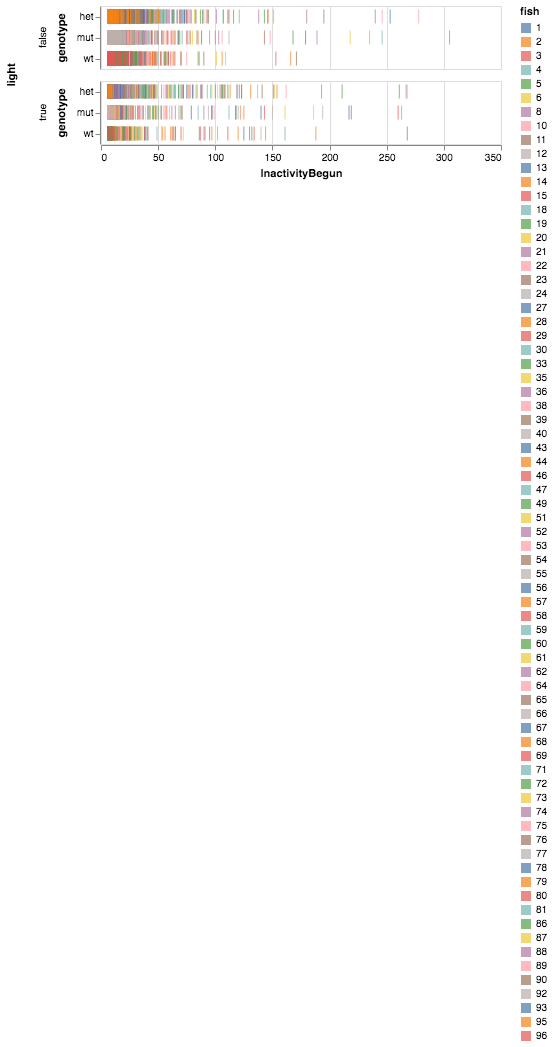

In [26]:
alt.Chart(df_inactive
    ).mark_tick(
    ).encode(
        x='InactivityBegun:Q',
        y=alt.Y('genotype:N', title='genotype'),
        color=alt.Color('location:N', title="fish"),
        row = "light:N"
    )

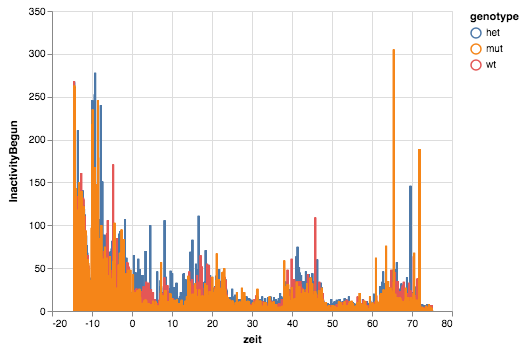

In [55]:
alt.Chart(df
    ).mark_line(
    ).encode(
        y='InactivityBegun:Q',
        x=alt.X('zeit:Q'),
        color=alt.Color('genotype:N', title="genotype")
    )

In [27]:
averaged_df = df.groupby(['genotype', 'zeit_ind']).mean().reset_index()

# Location columns is irrelovant
del averaged_df['location']

# Take a look
averaged_df.head()

,genotype,zeit_ind,activity,zeit,day,light,InactivityBegun
0,het,-869,1.644118,-14.480801,4.0,True,64.147059
1,het,-868,1.814706,-14.464167,4.0,True,13.500000
2,het,-867,1.629412,-14.447500,4.0,True,1.176471
3,het,-866,1.682353,-14.430833,4.0,True,1.617647
4,het,-865,2.194118,-14.414167,4.0,True,0.000000


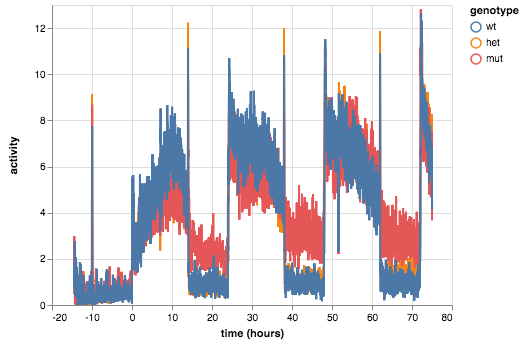

In [28]:
alt.Chart(averaged_df
    ).mark_line(
        strokeJoin='bevel'
    ).encode(
        x=alt.X('zeit:Q', title='time (hours)'),
        y='activity:Q',
        color=alt.Color('genotype:N', sort=['wt', 'het', 'mut']),
        order='zeit:Q'
    )

In [29]:
def load_and_resample(activity_file, genotype_file, zeitgeber_0, resample_rule=None):
    """Load and resample activity data.
    Assumes genotype file has columns corresponding 
    to wild type, heterozygote, and mutant.
    """
    # Load in the genotype file, call it df_gt for genotype DataFrame
    df_gt = pd.read_csv(genotype_file,
                        delimiter='\t',
                        comment='#',
                        header=[0, 1])
    
    # Rename columns
    df_gt.columns = ['wt', 'het', 'mut']
    
    # Melt to tidy
    df_gt = pd.melt(df_gt, var_name='genotype', value_name='location').dropna()
    
    # Reset index
    df_gt = df_gt.reset_index(drop=True)
    
    # Integer location names
    df_gt.loc[:,'location'] = df_gt.loc[:, 'location'].astype(int)
    
    # Read in activity data
    df = pd.read_csv(activity_file, comment='#')
    
    # Merge with genotype data
    df = pd.merge(df, df_gt)
    
    # Convert time to datetime
    df['time'] = pd.to_datetime(df['time'])
    
    # Column for light or dark
    df['light'] = (  (df['time'].dt.time >= pd.to_datetime('9:00:00').time())
                   & (df['time'].dt.time < pd.to_datetime('23:00:00').time()))
    
    if resample_rule is None:
        df_resampled = df
    else:
        # Group by location
        gb = df.groupby('location')

        # Make resampler
        resampler = gb.resample(resample_rule, on='time')

        # Resample with summing
        activity_resampled = resampler.sum()['activity']

        # Rescale sum with count
        activity_resampled *= 10 / resampler.count()['activity']

        # Reset the index
        activity_resampled = activity_resampled.reset_index()

        # Get a new DataFrame, resampled without summing.
        df_resampled = resampler.first()

        # Resampling happened on activity and time columns; delete
        del df_resampled['time']
        del df_resampled['location']

        # Reset index so resampled location and time indices become columns
        df_resampled = df_resampled.reset_index()

        # Add in the properly resampled activity
        df_resampled['activity'] = activity_resampled['activity']

    # Set the Zeitgeber time
    zeitgeber_0 = pd.to_datetime(zeitgeber_0)
    df_resampled['zeit'] = (df_resampled['time'] - zeitgeber_0).dt.total_seconds() / 3600

    return df_resampled

In [30]:
df_resample = load_and_resample('../data/130315_1A_aanat2.csv', 
                       '../data/130315_1A_genotypes.txt', 
                       '2013-03-16 9:00:00',
                       resample_rule='10min')

In [35]:
df_resample.head()

,location,time,activity,zeit,zeit_ind,day,genotype,light
0,1,2013-03-15 18:30:00,85.888889,-14.500000,-869,4,het,True
1,1,2013-03-15 18:40:00,4.500000,-14.333333,-860,4,het,True
2,1,2013-03-15 18:50:00,0.000000,-14.166667,-850,4,het,True
3,1,2013-03-15 19:00:00,0.000000,-14.000000,-840,4,het,True
4,1,2013-03-15 19:10:00,0.000000,-13.833333,-830,4,het,True


In [38]:
averaged_df_resample = df_resample.groupby(['genotype', 'zeit_ind']).mean().reset_index()

# Location columns is irrelovant
del averaged_df_resample['location']

# Take a look
averaged_df_resample.head()

,genotype,zeit_ind,activity,zeit,day,light
0,het,-869,17.921569,-14.500000,4.0,True
1,het,-860,7.900000,-14.333333,4.0,True
2,het,-850,4.891176,-14.166667,4.0,True
3,het,-840,4.041176,-14.000000,4.0,True
4,het,-830,1.411765,-13.833333,4.0,True


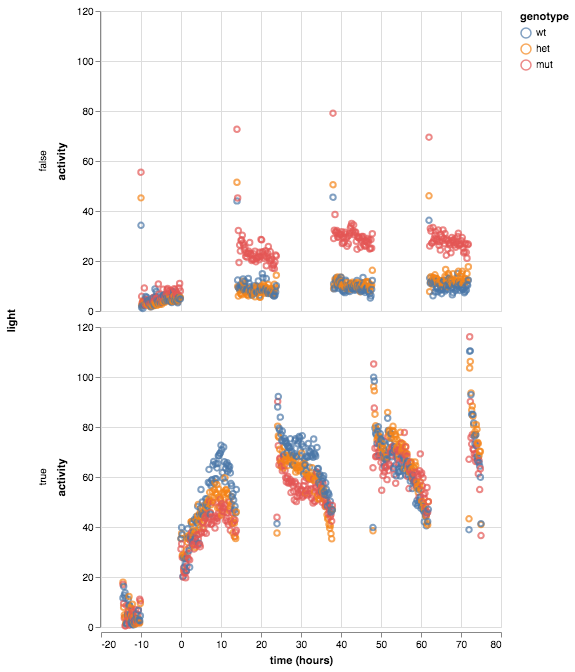

In [44]:
alt.Chart(averaged_df_resample
    ).mark_point(
        strokeJoin='bevel'
    ).encode(
        x=alt.X('zeit:Q', title='time (hours)'),
        y='activity:Q',
        color=alt.Color('genotype:N', sort=['wt', 'het', 'mut']),
        order='zeit:Q',
        row = alt.Row('light:N')
    )